# Training and Evaluating LDA Models

## Training

This is the the heart of our LDA Pipeline. After loading the preprocessed data from [the previous notebook](02.2_LDA-Preprocessing.ipynb), we will use the sklearn implementation of LDA to train our model. We will also use the GridSearchCV class to find the best hyperparameters for our model.

Other popular Python-Implementations of LDA include [gensim](https://radimrehurek.com/gensim/models/ldamodel.html) and [lda](https://pypi.org/project/lda/).

All of these adhere to a very similar API and differ only in minor details. Gensim in particular is a very popular library for topic modeling with a lot of additional functionality, so you might want to check it out.

### Loading Preprocessed Data

In [71]:
import json

with open('../data/articles/train.preprocessed.json', 'r') as f:
    data = json.load(f)

with open('../data/articles/test.preprocessed.json', 'r') as f:
    data_test = json.load(f)

with open('../data/articles/train.json', 'r') as f:
    labels = json.load(f)
    labels = [doc['label'] for doc in labels]
    labels_map = {label: i for i, label in enumerate(set(labels))}
    labels = [labels_map[label] for label in labels]


/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Setting up the Pipeline

The sklearn LDA-implementation ingests a document-term-matrix (DTM) as input. This is a matrix where each row represents a document and each column represents a term. The values in the matrix represent the frequency of the term in the document.

To create a DTM from our data, we will use the gensim dictionary. This class takes a list of strings as input, generates a vocabulary as an intermediate step, and outputs a DTM.
It allows us to prune that vocabulary by setting a minimum and maximum document frequency for the terms in the vocabulary. This is useful to remove very rare terms that are likely to be typos or very common terms that are unlikely to be informative.

In [3]:
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents and filter out frequent and rare words.
dictionary = Dictionary(data)
dictionary.filter_extremes(no_below=30, no_above=0.85)

# Build the Document Term Matrix (DTM)
dtm = [dictionary.doc2bow(doc) for doc in data]

N, V = len(dtm), len(dictionary)
print("Found a vocabulary of {} unique terms in {} documents".format(V, N))


Found a vocabulary of 4442 unique terms in 2977 documents


### Fitting the Model

To perform LDA, we need to choose three hyperparameters. The first is the number of topics we want to find, $K$. The second is the $\alpha$ parameter, which controls the sparsity of the document-topic matrix. The third is the $\eta$ parameter, which controls the sparsity of the topic-term matrix. 

Both sklearn and gensim allow users to ommit the latter two parameters, in which case they are set to a default value of $1/K$. While this is a good starting point, we will learn how to fine-tune these parameters later on.

$K$ has no such obvious default value, which, without further knowledge of our data, forces us to choose a random starting point. Even though we know our particular dataset consists of eight sections, we will start with $K=10$ and see how the model performs. Later on, we will learn how to evaluate the model and use that to choose a better value for $K$.

In [17]:
# For better performance, we use the multicore implementation of LDA
from gensim.models import LdaMulticore

# Explicitly setting the number of topics
K = 10

# Alpha and eta would default to these values
# We set them only for clarity
alpha = 1 / K
eta = 1 / K

# Passes determines the number of training passes through the corpus
# A larger number might yield slightly better results, linearly increases training time
passes = 10

# Train the model on the corpus.
lda_model = LdaMulticore(dtm, K, id2word=dictionary,
                         alpha=alpha, eta=eta, passes=passes)


/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Evaluation

Evaluating topic models is a difficult task. 
Typically, there are no ground truth labels, so we cannot use metrics like precision and recall. 
Instead, besides manual inspection, we usually have to rely on metrics that measure the *coherence* of the topics. 
These metrics are based on the assumption that a good topic model will produce topics that are both distinct and human interpretable.

### Manual Inspection

It is useful to manually explore the topics that the model has found. To do this, we will use the `show_topics` method of the gensim LdaModel.

In [18]:
lda_model.show_topics(num_topics=K, num_words=5)


/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(3, '0.029*"I" + 0.008*"New" + 0.007*"year" + 0.007*"York" + 0.007*"like"'),
 (1,
  '0.016*"company" + 0.012*"year" + 0.007*"percent" + 0.006*"billion" + 0.006*"million"'),
 (2,
  '0.018*"company" + 0.011*"Google" + 0.009*"use" + 0.009*"I" + 0.008*"app"'),
 (4,
  '0.009*"year" + 0.008*"like" + 0.007*"find" + 0.007*"study" + 0.007*"scientist"'),
 (6,
  '0.019*"Facebook" + 0.012*"company" + 0.009*"people" + 0.009*"post" + 0.008*"ad"'),
 (7, '0.021*"I" + 0.012*"team" + 0.011*"game" + 0.008*"play" + 0.008*"year"'),
 (0,
  '0.011*"people" + 0.011*"patient" + 0.010*"vaccine" + 0.009*"virus" + 0.008*"health"'),
 (8,
  '0.016*"Trump" + 0.008*"president" + 0.007*"United" + 0.006*"House" + 0.006*"President"')]

The generated topics all look very similar. *I*, *year*, and *company* are among the top five words of almost all topics, which makes for poor interpretability and distinctiveness.

To mitigate this, we could take two approaches. 
The first is to add words like *I* to the stopword list, effectively removing them from the vocabulary.
While this makes sense for some words and is common practice, *company* or *year* appear to actually carry important semantic information.

The second approach is to tune the hyperparameters of the model.
In particular, we can try to increase the sparsity of the topic-term matrix by decreasing $\eta$.

In [20]:
lda_model = LdaMulticore(dtm, K, id2word=dictionary,
                         alpha=alpha, eta=eta, passes=passes)

lda_model.show_topics(num_topics=K, num_words=5)


/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.012*"study" + 0.009*"find" + 0.008*"I" + 0.008*"researcher" + 0.008*"University"'),
 (1,
  '0.013*"company" + 0.010*"Trump" + 0.009*"Facebook" + 0.006*"I" + 0.006*"president"'),
 (2,
  '0.007*"Trump" + 0.006*"year" + 0.006*"country" + 0.006*"United" + 0.006*"party"'),
 (3,
  '0.010*"like" + 0.009*"year" + 0.008*"I" + 0.007*"company" + 0.007*"use"'),
 (4,
  '0.017*"vaccine" + 0.013*"people" + 0.009*"virus" + 0.008*"health" + 0.007*"variant"'),
 (5,
  '0.019*"China" + 0.012*"chinese" + 0.011*"North" + 0.011*"Korea" + 0.009*"United"'),
 (6,
  '0.013*"year" + 0.011*"percent" + 0.010*"company" + 0.006*"drug" + 0.006*"patient"'),
 (7,
  '0.009*"New" + 0.009*"York" + 0.008*"people" + 0.008*"kill" + 0.007*"year"'),
 (8,
  '0.007*"case" + 0.007*"law" + 0.007*"court" + 0.006*"year" + 0.005*"government"'),
 (9, '0.029*"I" + 0.010*"team" + 0.009*"game" + 0.009*"year" + 0.008*"time"')]

We can clearly see that the topics have become more distinct. While *company* still appears in multiple topics, more meaningful word-combinations like *vaccine*, *virus*, and *variant* or *China*, *chineses*, *North*, and *Korea* have surfaced.

*North Korea* is a curious example at this point, as both words appear indepent, yet clearly belong to a single semantic unit. The [chapter on advanced methods](LDA-04-Advanced.ipynb) will demonstrate how one can deal with this.

### Visualizing the Topics

Besides reading through the most prominent words of each topic, visualizing the size and similarity of the topics can be another useful tool for manual inspection.

pyLDAvis is the most common Python library for such visualizations of LDA models. It is based on the R package LDAvis, which is described in [this paper](https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf).

The visualization consists of two parts. The left part shows a two-dimensional projection of the topics. The right part shows the top 30 terms for the selected topic. The size of the terms is proportional to the frequency of the term in the corpus. The distance between the terms is proportional to the distance between the terms in the topic-term matrix.

In [23]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, dtm, dictionary)


/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.107776  0.005378       1        1  13.195643
6      0.011087  0.050238       2        1  12.915234
9      0.058085 -0.135039       3        1  12.774549
0      0.120249  0.041049       4        1  11.337941
8     -0.107196  0.016111       5        1  10.968875
3      0.073379 -0.050859       6        1  10.788846
2     -0.099559 -0.007345       7        1  10.666760
4      0.053444  0.143878       8        1   7.363366
7      0.010453 -0.035498       9        1   4.999131
5     -0.012167 -0.027913      10        1   4.989656, topic_info=             Term         Freq        Total Category  logprob  loglift
2443      vaccine  1358.000000  1358.000000  Default  30.0000  30.0000
484         China  1185.000000  1185.000000  Default  29.0000  29.0000
933         virus  1298.000000  1298.000000  Default  28.0000  28.0000
514         Trump  2836.000000  2836.000000  Default  27.0000  27.0000
33              I  8931.000000  8931.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
351         world   165.708500  1617.727796  Topic10  -5.7335   0.7193
324        system   157.798563  1607.249892  Topic10  -5.7824   0.6768
200       include   161.157034  2927.415454  Topic10  -5.7613   0.0983
1208  ImageCredit   157.205588  1874.710553  Topic10  -5.7862   0.5191
56           York   157.225000  3283.366403  Topic10  -5.7860  -0.0411

[703 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
754       3  0.989948             0
754       6  0.008250             0
3126      3  0.989095  2014krasnaya
4193      3  0.989132     2014sochi
1829      1  0.046775    Affordable
...     ...       ...           ...
352       6  0.135019          year
352       7  0.090571          year
352       8  0.043031          year
352       9  0.049215          year
352      10  0.049215          year

[4150 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 10, 1, 9, 4, 3, 5, 8, 6])

We can clearly see a cluster of three very close topics, all of which contain the words *company*, *Trump*.
This is a good example of how the visualization can hint us towards finding the correct number of topics, which appear to be below 10 in our case.

To perform the search for the optimal number more rigorously, we will now turn to the coherence metric.

### Coherence

Coherence is a measure of the semantic similarity of the terms in a topic. A good coherence score indicates that the terms within a topic are more probable to coocure within the topic than outside of it.

To generate the optimal number of topics, we have to compute the LDA-Model for every number of topics we are interested in. Usually, one starts by computing the model for a small number of topics and then increases the number of topics until the coherence score starts to decrease.

In [106]:
from tqdm import tqdm
from gensim.models import CoherenceModel
from os import makedirs
from os.path import join

model_path = join("..", "data", "lda-models")
makedirs(model_path, exist_ok=True)

number_of_topics = [2, 4, 8, 12, 16, 32, 64, 128]
coherence_scores = []

pbar = tqdm(number_of_topics, ncols=100)
for K in pbar:
    # We need to adjust alpha and eta for the number of topics
    alpha = 1 / K
    eta = 1 / K

    pbar.set_description("Computing LDA")
    lda_model = LdaMulticore(dtm, K, id2word=dictionary,
                             alpha=alpha, eta=eta, passes=1, random_state=123)
    lda_model.save(join(model_path, "lda_model_{}.model".format(K)))

    pbar.set_description("Computing Coherence")
    cm_cv = CoherenceModel(model=lda_model, corpus=dtm,
                           texts=data_test,
                           dictionary=dictionary, coherence='c_v')
    cm_umass = CoherenceModel(model=lda_model, corpus=dtm,
                              texts=data_test,
                              dictionary=dictionary, coherence='u_mass')
    cm_uci = CoherenceModel(model=lda_model, corpus=dtm,
                            texts=data_test,
                            dictionary=dictionary, coherence='c_uci')
    cm_npmi = CoherenceModel(model=lda_model, corpus=dtm,
                             texts=data_test,
                             dictionary=dictionary, coherence='c_npmi')

    coherence_scores.append({
        'K': K,
        'c_v': cm_cv.get_coherence(),
        'u_mass': cm_umass.get_coherence(),
        'c_uci': cm_uci.get_coherence(),
        'c_npmi': cm_npmi.get_coherence()
    })


/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Computing Coherence: 100%|████████████████████████████████████████████| 8/8 [02:11<00:00, 16.38s/it]


We plot the coherence score for the different numbers of topics and choose the number of topics that maximizes the coherence score.

/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


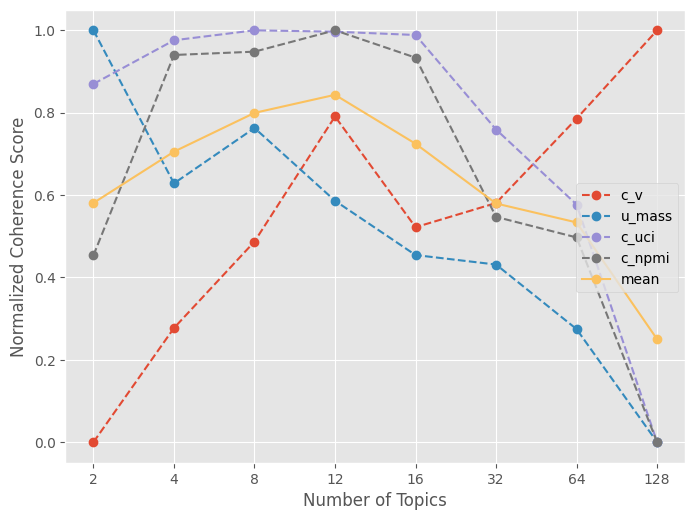

In [141]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

fig, ax0 = plt.subplots(figsize=(8, 6), dpi=100)
mean_score = np.zeros(len(coherence_scores))

# Normalize and plot the scores
for metric in ['c_v', 'u_mass', 'c_uci', 'c_npmi']:
    min_score = min([score[metric] for score in coherence_scores])
    max_score = max([score[metric] for score in coherence_scores])
    normalized_score = [(score[metric] - min_score) /
                        (max_score - min_score) for score in coherence_scores]

    mean_score += normalized_score
    ax0.plot(normalized_score, '--', label=metric, marker='o')

mean_score /= 4
ax0.plot(mean_score, label='mean', marker='o')

ax0.set_ylabel("Normalized Coherence Score")
ax0.set_xlabel("Number of Topics")
ax0.set_xticks(range(len(number_of_topics)))
ax0.set_xticklabels([str(K) for K in number_of_topics])

fig.legend(loc='center right', bbox_to_anchor=(.9, 0.5))


This graph fits our previous knowledge: The first dataset has eight topics, which also yields a high coherence score.
However, the disagreement between the different measures of coherence is quite substantial, with $c_v$ being the most obvious outlier. While $c_v$ has some known issues, the disagreement between the remaining measures, in particular for a small number of topics, still poses a problem.

If we were to rely on the coherence score alone to choose the number of topics, we would need to dig deeper into the differences between the measures and their respective strengths and weaknesses.
There is no clear consensus on which measure is the best, so we will not go into detail here.

We also plot the confusion matrix of the optimal model against the true labels to further investigate the model's performance.
This step is only possible because we have access to the true labels in this case. In general, we will have to rely on manual inspection and coherence scores.

/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
 88%|████████████████████████████████████████████████████████▉        | 7/8 [00:19<00:02,  2.85s/it]


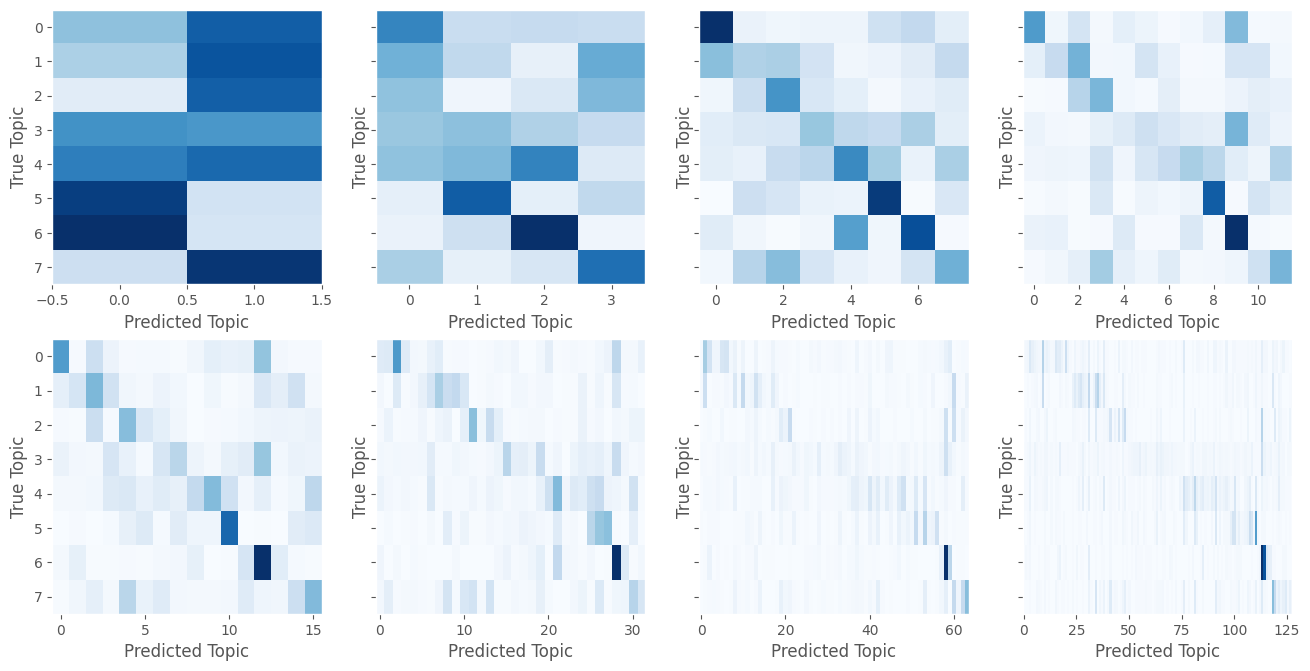

In [134]:
import numpy as np

fig, axs = plt.subplots(2, 4, figsize=(16, 8), dpi=100, sharey=True)
axs = axs.flatten()


def get_topic(lda, bow):
    preds = lda.get_document_topics(bow, minimum_probability=0.0)
    probs = [prob for _, prob in preds]
    index = [index for index, _ in preds]
    return index[np.argmax(probs)]


for ax, nr in zip(axs, tqdm(number_of_topics, ncols=100)):
    T_true, T_pred = 8, nr
    conf = np.zeros((T_true, T_pred))

    model = LdaMulticore.load(
        join(model_path, "lda_model_{}.model".format(nr)))

    topics = [get_topic(model, doc) for doc in dtm]

    for label_gt, label_pred in zip(labels, topics):
        conf[label_gt][label_pred] += 1

    conf_top_pred = np.argmax(conf, axis=0)
    conf_order_by_pred = np.argsort(conf_top_pred)
    conf_ordered_by_pred = conf[:, conf_order_by_pred]

    ax.imshow(conf_ordered_by_pred, cmap='Blues', aspect='auto',
              interpolation='nearest', vmin=0)
    ax.set_xlabel("Predicted Topic")
    ax.set_ylabel("True Topic")
    ax.grid(False)


### Grid-Search for $\alpha$ and $\eta$

While the number of topics is the most important hyperparameter, we already saw the impact the $\alpha$ and $\eta$ parameters can have on the quality of the topics.

To find the optimal values for these parameters, we will use the GridSearchCV class. This class takes a model and a dictionary of hyperparameters as input and computes the model for all combinations of the hyperparameters. It then returns the model with the best score.

In theory, one should optimize all three parameters at once. However, this is computationally very expensive. Therefore, we will fix the number of topics to the optimal value we found in the previous step and only optimize $\alpha$ and $\eta$.

In [148]:
import numpy as np

K = 8
array_alpha = np.logspace(-4, 4, 5, base=2) * 1 / K
array_eta = np.logspace(-4, 4, 5, base=2) * 1 / K
results = np.zeros((len(array_alpha), len(array_eta)))


def compute_coherence(alpha, eta):
    lda_model = LdaMulticore(dtm, K, alpha=alpha, eta=eta, random_state=123)
    cm = CoherenceModel(model=lda_model, corpus=dtm,
                        texts=data_test,
                        dictionary=dictionary, coherence='c_uci')
    return cm.get_coherence()


print("Starting grid search")
pbar = tqdm(total=len(array_alpha) * len(array_eta),
            ncols=100, position=0, leave=True)

for i, alpha in enumerate(array_alpha):
    for j, eta in enumerate(array_eta):
        pbar.set_description("alpha: {:.4f}, eta: {:.4f}".format(alpha, eta))
        results[i, j] = compute_coherence(alpha, eta)
        pbar.update()


/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Starting grid search


100%|███████████████████████████████████████████████████████████████| 25/25 [02:46<00:00,  6.56s/it]

We can now plot the results of the grid-search. The plot shows the coherence score for the different values of $\alpha$ and $\eta$.
The optimal values are the ones that maximize the coherence score.

Optimal parameters: alpha=0.0078125, eta=0.0078125


/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


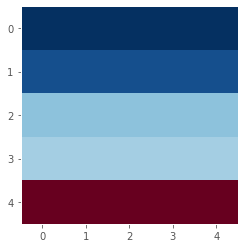

In [149]:
optimal = np.unravel_index(np.argmax(results), results.shape)
optimal_parameters = (array_alpha[optimal[0]], array_eta[optimal[1]])

print("Optimal parameters: alpha={}, eta={}".format(*optimal_parameters))

plt.imshow(results, cmap='RdBu', interpolation='nearest')
plt.grid(False)


### Exploring the Optimal Model

Using the optimal parameters, we can again use pyLDAvis to visualize the topics.
Further, the gensim model itself has convenience methods to explore the topics. In particular, we can use the `show_topics` method to print the top terms for each topic.

In [37]:
K = 4
lda_model = train_lda_model(
    dtm, K, alpha=optimal_parameters[0], eta=optimal_parameters[1])

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, dtm, dictionary, mds='tsne')


PreparedData(topic_coordinates=               x           y  topics  cluster       Freq
topic                                                   
0     -84.698318   -4.284818       1        1  34.828347
3      23.969799  -64.942490       2        1  24.150054
1     -24.041286  104.384781       3        1  21.974277
2      84.627121   43.728096       4        1  19.047322, topic_info=         Term         Freq        Total Category  logprob  loglift
33          I  8653.000000  8653.000000  Default  30.0000  30.0000
734    people  4968.000000  4968.000000  Default  29.0000  29.0000
319     study  2106.000000  2106.000000  Default  28.0000  28.0000
2443  vaccine  1288.000000  1288.000000  Default  27.0000  27.0000
200   include  2863.000000  2863.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
99       come   481.653728  2833.188906   Topic4  -6.0061  -0.1137
230     month   436.345447  2261.812694   Topic4  -6.1048   0.0128
346       way   428.829024  2177.095175   Topic4  -6.1222   0.0336
349      work   485.050604  3452.327575   Topic4  -5.9990  -0.3043
796      case   422.275782  2093.154759   Topic4  -6.1376   0.0575

[334 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
4306      1  0.506562  1/25/2018
4306      2  0.189961  1/25/2018
4306      3  0.221621  1/25/2018
4306      4  0.094980  1/25/2018
1698      1  0.258781  1/26/2018
...     ...       ...        ...
1373      4  0.355373      wound
352       1  0.346127       year
352       2  0.298614       year
352       3  0.213612       year
352       4  0.141627       year

[924 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3])